# Question 4: combination of Solow & Romer

General notes:
- The code is written in a way that is easy to read and understand and may not follow all programming guidelines (https://peps.python.org/pep-0008/): e.g. in your own code you may wish to separate functions and the main code. That is, have separate scripts containing functions and a main script that calls these functions. For a minimal example see the use for assignment_06_plots.py.
- As the code for plotting can be tedious, the plotting functions are delegated to assignment_06_plots.py. The functions are made available in this script via the <<import assignment_06_plots as a6p>> statement. The functions are called in the main code below.
"""

In [13]:
import matplotlib.pyplot as plt

# Load libraries
import numpy as np

import assignment_06_plots as a6p

# plt.rcParams["text.usetex"] = True


# Set parameters
k_ss = 2  # steady state capital
alpha = 1.0 / 3.0  # capital share
delta = 0.2  # depreciation rate
g_L = 0.01  # population growth rate
s_I = 0.2  # savings rate


# use backward engineering to get level of A consistent with specified k_ss
def find_A(delta, g_L, s_I, alpha, k_ss):
    A = ((delta + g_L) / s_I) ** (1 / (1 - alpha)) * k_ss
    return A


A = find_A(delta, g_L, s_I, alpha, k_ss)
print("A =", A)

k_ss_check = (s_I * A ** (1 - alpha) / (delta + g_L)) ** (1 / (1 - alpha))
print("if formulas are correct then the next two numbers are the same")
print(f"k_ss = {k_ss} and k_ss_check = {k_ss_check}")

# more direct way to check (often a good idea to do in any program to check for unexpected behaviour)
assert np.isclose(k_ss, k_ss_check)
# assert k_ss == k_ss_check # with floating point numbers, better to use np.isclose (uncomment to see why; interested students can also look up https://docs.python.org/3/tutorial/floatingpoint.html)




A = 2.1518596608515157
if formulas are correct then the next two numbers are the same
k_ss = 2 and k_ss_check = 2.0


# Solow growth model with constant TFP level

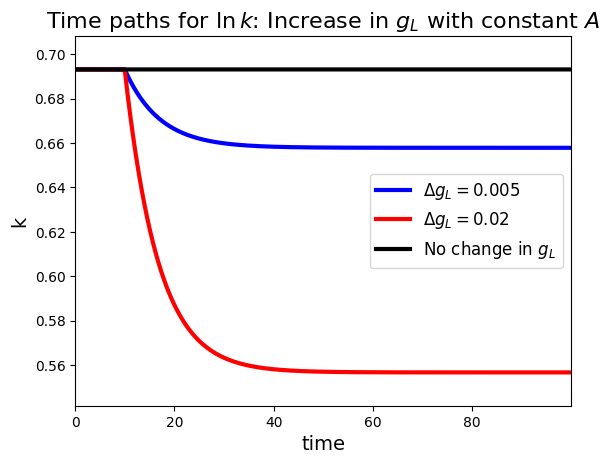

In [10]:
# Define parameters
T = 10_000
dt = 0.01
k_time = np.zeros((T, 3))
time = np.zeros(T)
k_time[0, :] = k_ss * np.ones((1, 3))
time[0] = 0  # not necesary if time starts at 0

# Consider 3 cases: (i) no change (ii) small change (iii) large change
g_L_begin = np.array([0.01, 0.010, 0.01])
g_L_later = np.array([0.01, 0.015, 0.03])


# Define Law of mation for capital per worker
def get_knext(k, g_L, s_I, A, alpha, delta, dt):
    output = k**alpha * A ** (1 - alpha)
    invest = s_I * output
    knext = k + (invest - (delta + g_L) * k) * dt
    return knext


for t in range(T - 1):
    if t < (1000 - 1):  # subtract one for Python's 0-indexing
        g_L = g_L_begin
    else:
        g_L = g_L_later

    # Update capital for each g_L
    for j in range(3):
        k_time[t + 1, j] = get_knext(k_time[t, j], g_L[j], s_I, A, alpha, delta, dt)

    time[t + 1] = time[t] + dt


# Plot using custom function from assignment_06_plots.py
fig1, ax1 = a6p.plot_ln_k_solow(
    k_time, time, title=r"Time paths for $\ln{k}$: Increase in $g_L$ with constant $A$"
)


# Solow growth model with exogenous TFP growth

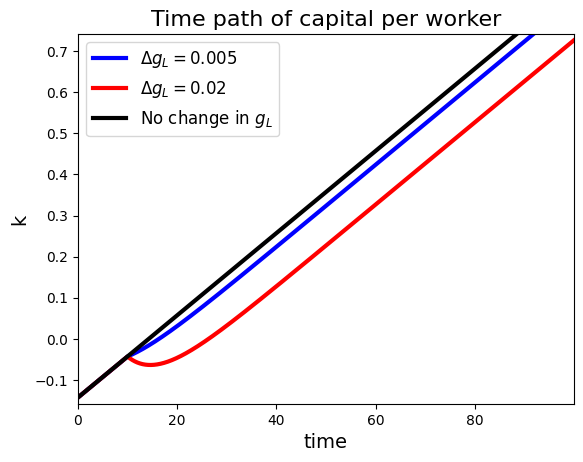

In [11]:
# Set parameters
g_L = 0.01
g_A = 0.01
T = 10_000
dt = 0.01
ktilde_ss = (s_I / (delta + g_L + g_A)) ** (1 / (1 - alpha))

k_time = np.zeros((T, 3))
A_time = np.zeros(T)
time = np.zeros(T)
g_L_begin = np.array([0.01, 0.010, 0.01])
g_L_later = np.array([0.01, 0.015, 0.03])
A_time[0] = 1.0
k_time[0, :] = ktilde_ss * A_time[0]
time[0] = 0  # not necesary if time starts at 0

# Solve by iterating
for t in range(T - 1):
    A_time[t + 1] = A_time[t] + g_A * A_time[t] * dt  # since (dA/dt)/A = g_A
    # note that the time iteration block is exactly the same as before
    # just because we have to focus on ktilde to understand what the steady
    # state is, does not mean that the law of motion for k (and K) change
    if t < 1000 - 1:  # subtract one for Python's 0-indexing
        g_L = g_L_begin
    else:
        g_L = g_L_later

    for j in range(3):
        k_time[t + 1, j] = get_knext(
            k_time[t, j], g_L[j], s_I, A_time[t], alpha, delta, dt
        )

    # update time
    time[t + 1] = time[t] + dt

fig2, ax2 = a6p.plot_ln_k_exo_TFP(k_time, time)




# Solow growth model with endogenous TFP growth from Romer

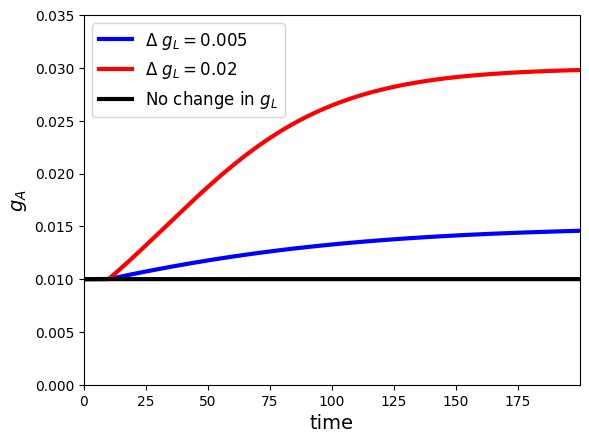

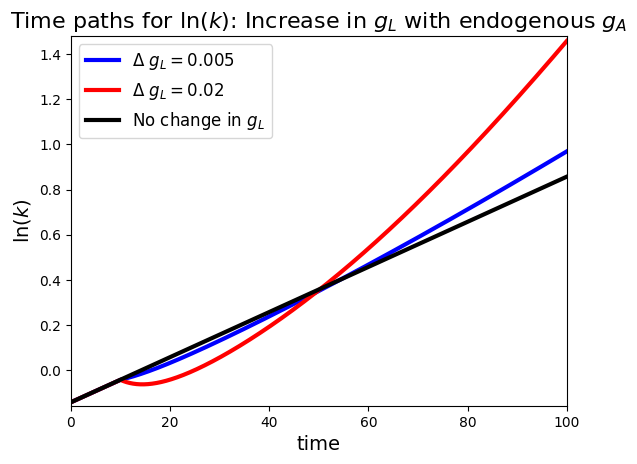

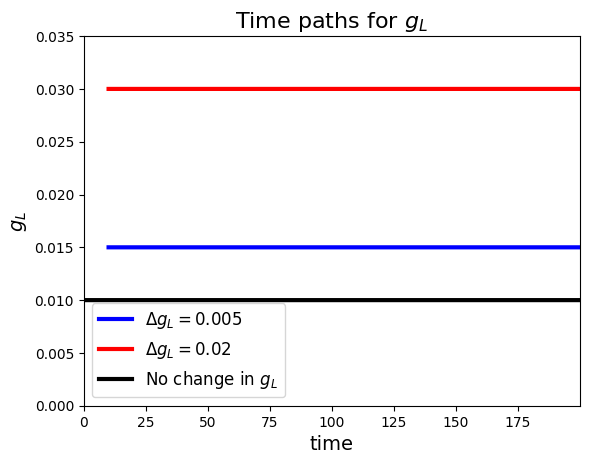

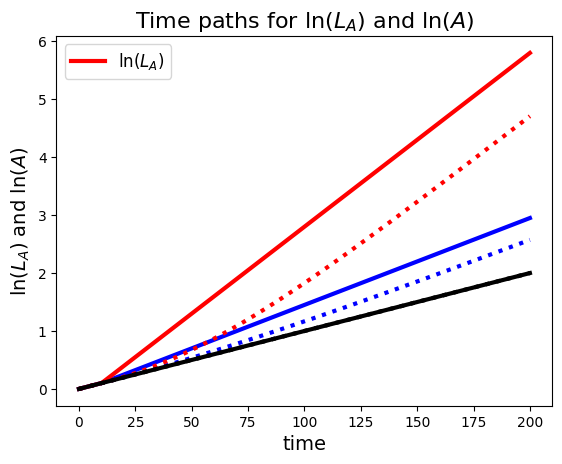

In [12]:
# Set parameters
g_L = 0.01
theta = 0.01
T = 20_000
dt = 0.01
k_time = np.zeros((T, 3))

# three different series for endogenous A since (eventually) 3 different values for g_L
# L_A is the mass of researchers NOT L/A
A_time = np.zeros((T, 3))
g_A_time = np.zeros((T, 3))
L_A_time = np.zeros((T, 3))  # same here

time = np.zeros(T)

# we use that g_A=g_L in steady state when A is determined a la Romer
g_A = g_L
ktilde_ss = (s_I / (delta + g_L + g_A)) ** (1 / (1 - alpha))
A_time[0, :] = np.ones((1, 3))
L_A_time[0, :] = g_L * A_time[0, :] / theta  # so we start at steady state value for L/A
k_time[0, :] = ktilde_ss * A_time[0, :]
time[0] = 0
g_A_time[0, :] = np.ones((1, 3)) * g_L


# Define function that update share of researchers
def get_L_Anext(L_A, g_L, dt):
    return L_A + g_L * L_A * dt


# Define function that update endogenous TFP
def get_Anext(A, L_A, theta, dt):
    return A + A * (theta * (L_A / A)) * dt


for t in range(T - 1):
    if t < 1000 - 1:
        g_L = g_L_begin
    else:
        g_L = g_L_later

    for j in range(3):
        # note that A_time is now inside this block since it will depend on value of g_L
        L_A_time[t + 1, j] = get_L_Anext(L_A_time[t, j], g_L[j], dt)

        # update A
        A_time[t + 1, j] = get_Anext(A_time[t, j], L_A_time[t, j], theta, dt)

        # after updating endogenous A, we can use the same law of motion for k as before
        k_time[t + 1, j] = get_knext(
            k_time[t, j], g_L[j], s_I, A_time[t, j], alpha, delta, dt
        )

        # get TFP growth
        g_A_time[t + 1, j] = theta * L_A_time[t + 1, j] / A_time[t + 1, j]

    time[t + 1] = time[t] + dt

# Plotting output
fig3, ax3 = a6p.plot_g_A_endo_TFP(
    g_A_time,
    time,
    title=r"Time paths for $g_A$: Increase in $g_L$ with endogenous $g_A$",
)

fig4, ax4 = a6p.plot_ln_k_A_endo_TFP(
    k_time,
    time,
    title=r"Time paths for $\ln(k)$: Increase in $g_L$ with endogenous $g_A$",
)

fig5, ax5 = a6p.plot_g_L_endo_TFP(g_L_later, time, title=r"Time paths for $g_L$")

fig6, ax6 = a6p.plot_log_L_A(
    L_A_time, A_time, time, title=r"Time paths for $\ln(L_A)$ and $\ln(A)$"
)

# Show plots
plt.show()
